# <span style="font-family:'cursive';">A Customer Churn Prediction Model</span>

<img src="222.PNG" alt="Alt text" width="500"/>


## 

### <span style="font-family:'cursive';"> What is customer churn and how can it be reduced? </span>

In today's highly competitive business landscape, the ability to identify and retain at-risk customers can significantly impact a company's profitability and long-term success


**Customer churn** is when customers <u>cease</u> their relationship with a company or business, which can occur for various reasons such as dissatisfaction with services, competitive offers, or changing needs

High churn rates can lead to revenue loss and increased customer acquisition costs. It's within this context that this project addresses the task of developing a churn prediction mechanism 

The outcome of this notebook is a churn prediction model to **forecast** which customers are likely to stop doing business

The data was provided by PWC

# <span style="font-family:'cursive';">Research Questions</span>

* What machine learning model is most effective in accurately predicting customer churn? 

* How well does the model generalize to new data after deployment?

* Which features are most indicative of potential churn?

* How effective are intervention strategies?



# <span style="font-family:'cursive';">Assumptions</span>

* This approach assumes that the provided features are relevant to predicting customer churn and that these features are not highly correlated

* Additionally, it assumes **churn rate stability** over the analyzed period, given the absence of specific date or time data for churn events.

### <span style="font-family:'cursive';"> Library Imports </span>
  

In [40]:
# data handling
import pandas as pd
import numpy as np
from tabulate import tabulate
from IPython.display import Image

# data visualization
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.compose import make_column_transformer

# model evaluation
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [36]:
df = pd.read_csv("churn.csv")
df = df.dropna()
df.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,0.0,No


# <span style="font-family:'cursive';">Description of data</span>


### <span style="font-family:'cursive'; ">   Data discovery - What do the columns in the provided data represent? </span>

| Description           | Value |
|-----------------------|-------|
| Number of rows        | 7032  |
| Number of columns     | 23    |
| Number of string columns | 17 |
| Number of float64 columns | 6  |


| Column           | Explanation                                                |
|------------------|-----------------------------------------------------------|
| Churn            | Represents whether the customer has churned (left the service) or not |
| SeniorCitizen    | Indicates if the customer is a senior citizen (0 for non-senior, 1 for senior) |
| tenure           | Represents the duration of customer tenure (in months) |
| MonthlyCharges   | Monthly charges for the customer |
| TotalCharges     | Total charges for the customer |
| numAdminTickets  | Number of administrative tickets or requests for non-technical reasons e.g. billing |
| numTechTickets   | Number of technical support tickets or requests for technical reasons e.g service disruption |
| customerID       | Unique customer identifier |
| gender           | Gender of the customer (Female, Male)  |
| Partner          | Indicates if the customer has a partner (Yes, No) |
| Dependents       | Indicates if the customer has dependents (Yes, No) |
| PhoneService     | Indicates if the customer has phone service (Yes, No) |
| MultipleLines    | Indicates if the customer has multiple phone lines |
| InternetService  | Type of internet service the customer has |
| OnlineSecurity   | Indicates if the customer has online security service |
| OnlineBackup     | Indicates if the customer has online backup service |
| DeviceProtection | Indicates if the customer has device protection service |
| TechSupport      | Indicates if the customer has technical support service |
| StreamingTV      | Indicates if the customer has streaming TV service |
| StreamingMovies  | Indicates if the customer has streaming movie service |
| Contract         | Type of contract the customer has (e.g., month-to-month, one-year, two-year) |
| PaperlessBilling | Indicates if the customer uses paperless billing (Yes, No) |
| PaymentMethod    | Method of payment chosen by the customer e.g electronic check |


#### <span style="font-family:'cursive';"> What are the unique values associated with the less obvious columns in the dataset </span>
  

In [3]:
columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
table = []

for column in columns:
    unique_values = df[column].unique()
    table.append([column, ", ".join(map(str, unique_values))])

headers = ['Column Name', 'Unique Values']
print(tabulate(table, headers, tablefmt="grid"))

+------------------+------------------------------------------------------------------------------------+
| Column Name      | Unique Values                                                                      |
+==================+====================================================================================+
| MultipleLines    | No phone service, No, Yes                                                          |
+------------------+------------------------------------------------------------------------------------+
| InternetService  | DSL, Fiber optic, No                                                               |
+------------------+------------------------------------------------------------------------------------+
| OnlineSecurity   | No, Yes, No internet service                                                       |
+------------------+------------------------------------------------------------------------------------+
| OnlineBackup     | Yes, No, No internet serv

#### <span style="font-family:'cursive';">What's the distribution of customer churn and non-churn counts?</span>
  

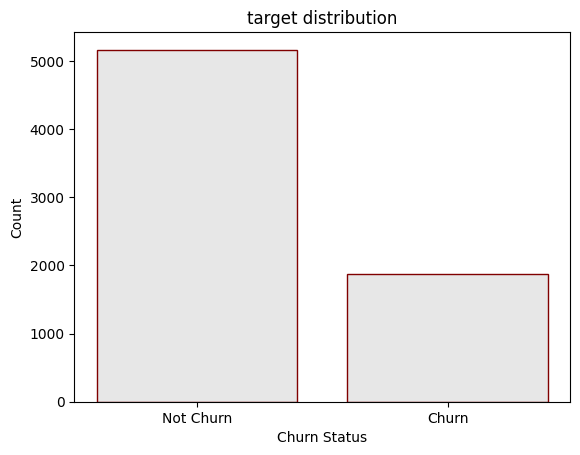

In [4]:
churn_counts = df['Churn'].value_counts()
bars = ['Not Churn', 'Churn']
height = [churn_counts[0], churn_counts[1]]

x_pos = range(len(bars))
plt.bar(x_pos, height, color=(0.1, 0.1, 0.1, 0.1), edgecolor='maroon')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(x_pos, bars)
plt.title('target distribution')
plt.show()   

## <span style="font-family:'cursive';"> Data preprocessing </span>

#### <span style="font-family:'cursive';"> I) Are there any outliers in numerical columns? </span>

Checking for outliers is essential to ensure that the model's predictive accuracy is not compromised by extreme values.

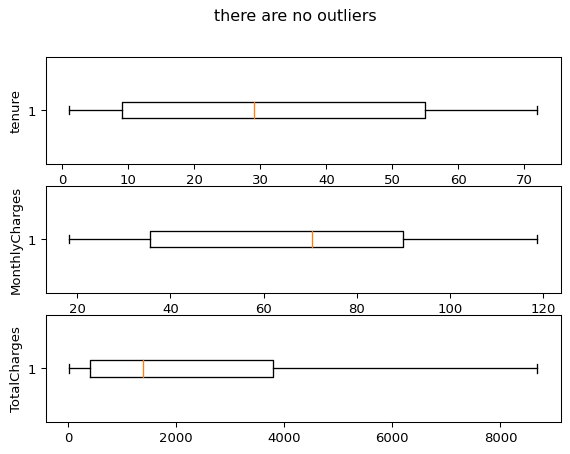

In [5]:
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
df2 = df[numerical_columns]

fig, axs = plt.subplots(3, 1, dpi=95, figsize=(7, 5))
i = 0
for col in df2.columns:
    axs[i].boxplot(df[col], vert=False)
    axs[i].set_ylabel(col)
    i += 1

plt.suptitle('there are no outliers')
plt.show()

#### <span style="font-family:'Roboto Slab';"> II) How is the target variable (churn column) label encoded? </span>

In [6]:
X, Y = df.drop(columns = ['Churn','customerID']), df['Churn']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y)
y = pd.Series(y)

#### <span style="font-family:'cursive';"> III) Train/test split  </span>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

#### <span style="font-family:'cursive';"> IV)  Feature engineering </span>

#### <span style="font-family:'cursive';"> Why use make_column_transformer, ordinal encoder and onehot encoder?  </span>


* Machine learning algorithms require data to be in a specific format and structure.  `make_column_transformer` tool simplifies feature engineering by efficiently managing various column types and their transformations, offering a convenient approach to prepare data.

* Contract and SeniorCitizen columns are encoded using OrdinalEncoder because they represent categorical variables with an inherent order

* The other categorical columns, which are binary or nominal, are encoded with OneHotEncoder, producing binary dummy variables while excluding the first category to prevent multicollinearity

* remainder='passthrough' ensures that any columns not explicitly mentioned in the transformers are passed through without any changes. 

In [8]:
column_trans = make_column_transformer (
    (OrdinalEncoder(), ['Contract', 'SeniorCitizen']),
    (OneHotEncoder(drop='first'), ['gender', 'Partner', 'Dependents', 'PhoneService','PaperlessBilling','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                       'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','PaymentMethod']),
    (StandardScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges']),
    remainder='passthrough')

X_train = column_trans.fit_transform(X_train)
X_test = column_trans.transform(X_test)

## 

### <span style="font-family:'cursive';"> Objective - To build a churn prediction model to identify at-risk customers </span>
  

### <span style="font-family:'cursive';"> Modelling </span>
  

In [9]:
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD, Adam, Adagrad
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

input_shape = X_train.shape[1]

#### <span style="font-family:'cursive';"> Quick overview of the Keras neural network architecture </span>
  

| Layer           | Neurons | Activation | BatchNorm | Dropout |
|-----------------|-------|------------|-----------|---------|
| Input           | -     | -          | -         | -       |
| Hidden 1        | 384   | ReLU       | Yes       | 20%     |
| Hidden 2        | 256   | ReLU       | Yes       | 30%     |
| Hidden 3-6      | 64    | ReLU       | Yes       | 0%      |
| Output          | 1     | Sigmoid    | -         | -       |

| Configuration |                   |
|-----------------------------|-------------------|
| Optimizer              | SGD with lr=0.001               |
|   Batch Size         | 64             |
| Callback                | Early Stopping Patience 10               |



In [10]:
def build_classification_model(input_shape):
    model = Sequential()

    model.add(Dense(units=384, activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))    
    model.add(Dense(units=256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.0))
    model.add(Dense(units=64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.0))
    model.add(Dense(units=64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.0))
    model.add(Dense(units=64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.0))

    model.add(Dense(units=1, activation='sigmoid'))

    optimizer = SGD(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_classification_model(input_shape)

## <span style="font-family:'cursive';"> Hyperparameter Tuning with Hyperopt </span>


- Hyperopt is an open-source Python library for hyperparameter optimization 

In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space = {
    'num_layers': hp.choice('num_layers', range(1, 10)),
    'units': hp.choice('units', [32, 64, 128, 256, 512]),
    'dropout': hp.uniform('dropout', 0, 1),
    'optimizer': hp.choice('optimizer', ['adam', 'sgd', 'rmsprop']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1.0)), 
    'batch_size': hp.choice('batch_size', [8, 16, 32, 64, 128, 256, 512, 1024])
}

def objective(params):
    model = Sequential()
    for i in range(params['num_layers']):
        model.add(Dense(units=params['units'], activation='relu'))
        model.add(Dropout(params['dropout']))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=5, batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return {'loss': 1 - accuracy, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

best_model = trials.best_trial['result']['model']
_, best_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print("Best Hyperparameters:", best)
print("Best Accuracy:", best_accuracy)
print("Best Loss:", trials.best_trial['result']['loss'])

100%|██████████| 30/30 [05:40<00:00, 11.34s/trial, best loss: 0.13290691375732422]
Best Hyperparameters: {'batch_size': 0, 'dropout': 0.26251054498785154, 'learning_rate': 0.35013255648244934, 'num_layers': 6, 'optimizer': 1, 'units': 3}
Best Accuracy: 0.8670930862426758
Best Loss: 0.13290691375732422


### <span style="font-family:'cursive';"> Model Training </span>  

In [12]:
monitor = EarlyStopping(monitor='val_loss', patience = 10)

initial_weights = model.get_weights()
train_accs = []
test_accs = []
training_sizes = np.array([500, 2000, 4000, 6000, 7000])

for size in training_sizes:
    X_train_frac, y_train_frac = X_train[:size], y_train[:size]

    model.set_weights(initial_weights)
    h2 = model.fit(X_train, y_train, validation_split = 0.3, epochs = 200, callbacks = monitor, validation_data = (X_test, y_test), verbose=0, batch_size= 64)

    train_accs.append(model.evaluate(X_train_frac, y_train_frac)[1])
    test_accs.append(model.evaluate(X_test, y_test)[1])

44/44 [==============================] - 0s 2ms/step - loss: 0.2990 - accuracy: 0.8621


## <span style="font-family:'cursive';"> Evaluation </span>  

### <span style="font-family:'cursive';"> 1. Learning Curve Analysis </span>  

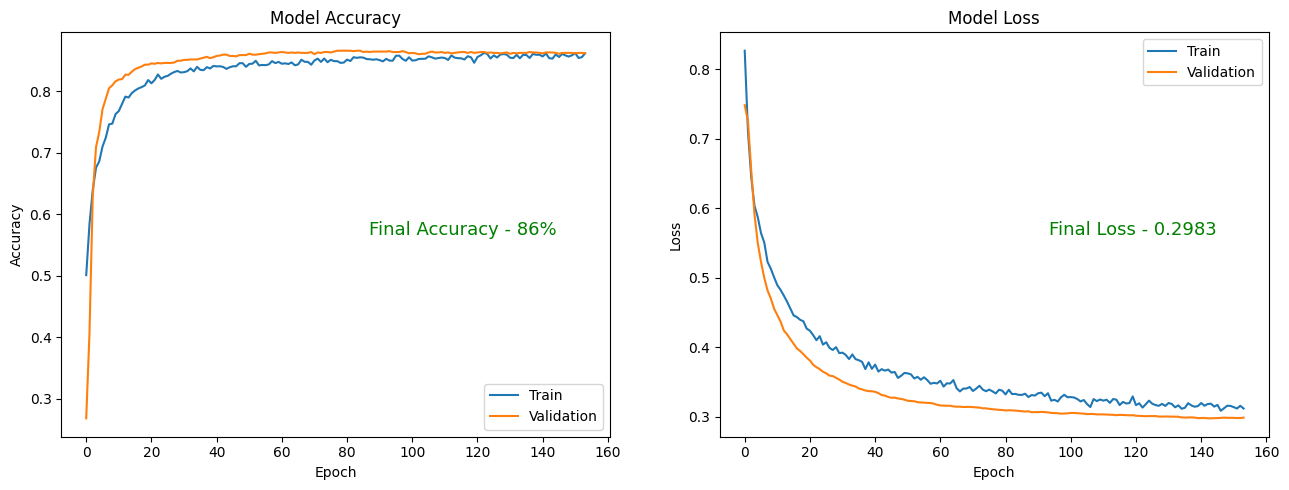

In [13]:
def plot_learning_curve(history):
    plt.figure(figsize=(13,5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    plt.text(0.56, 0.5, 'Final Accuracy - 86%', fontsize=13, color='green', transform=plt.gca().transAxes)

    # Plot training &  loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    plt.text(0.6, 0.5, 'Final Loss - 0.2983', fontsize=13, color='green', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    plt.show()

plot_learning_curve(h2)

### <span style="font-family:'cursive';"> 2. Would the model benefit from an increase in training data? </span>  

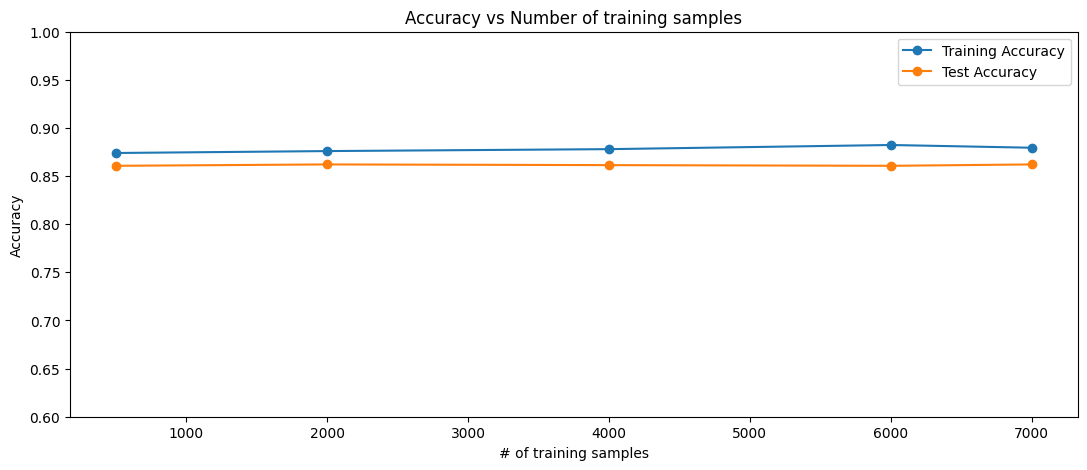

In [14]:
def plot_results(train_accs,test_accs):
  plt.figure(figsize=(13,5))
  plt.plot(training_sizes, train_accs, 'o-', label="Training Accuracy")
  plt.plot(training_sizes, test_accs, 'o-', label="Test Accuracy")
  plt.title('Accuracy vs Number of training samples')
  plt.xlabel('# of training samples')
  plt.ylabel('Accuracy')
  plt.legend(loc="best")
  plt.ylim(0.6, 1.0)  
  plt.show()

plot_results(train_accs, test_accs)

### <span style="font-family:'cursive';"> 3. Performance Analysis </span>  

44/44 [==============================] - 0s 2ms/step


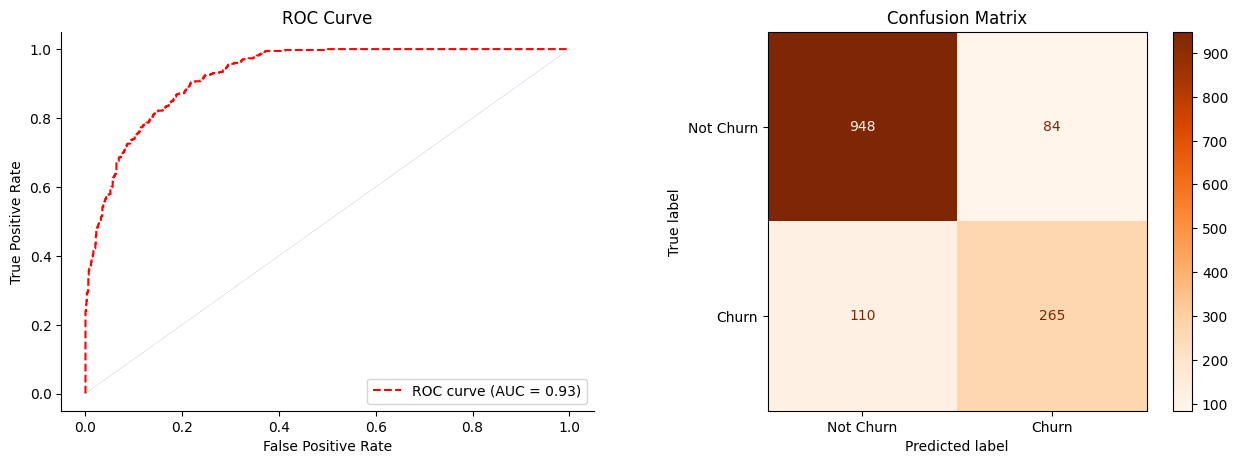

In [15]:
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Plot ROC Curve
axs[0].plot(fpr, tpr, color='red', lw=1.5, linestyle='--', label=f'ROC curve (AUC = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=0.1, linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].legend(loc='lower right')

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churn', 'Churn'])
disp.plot(ax=axs[1], cmap='Oranges', values_format='.0f')
axs[1].set_title('Confusion Matrix')

plt.subplots_adjust(wspace=0.8)
plt.tight_layout(pad=2) 
plt.show()

### <span style="font-family:'cursive';"> 4. How does the model compare to baseline models? </span>  

In [35]:
df1 = pd.DataFrame(dict(
    model=['Logistic Regression', 'Random Forest', 'Keras Neural Network'],
    percentage=[10, 9, 6],
    custom_labels=[0.3104, 0.3093, 0.2983]
))

fig = px.funnel(df1, x='percentage', y='model', title="Log Loss Comparison with Baseline Models",
                text='custom_labels', color_discrete_sequence=['brown'])
fig.update_yaxes(title_text='Model', scaleanchor="x", scaleratio=110.6, tickmode='array', tickvals=[2, 1, 0], ticktext=df['model'][::-1],
                 tickfont=dict(color='black', size=14))

fig.update_traces(textinfo='text')
fig.update_layout(height=400, width=900)
fig.show()

## <span style="font-family:'cursive';"> Results </span>  

In [41]:
from sklearn.metrics import confusion_matrix
threshold = 0.5  
predicted_labels = (y_pred > threshold).astype(int)
confusion_matrix = confusion_matrix(y_test, predicted_labels)
tp = confusion_matrix[1][1]  # True Positives
fn = confusion_matrix[1][0]  # False Negatives
# Calculate True Positive Rate (Sensitivity)
true_positive_rate = tp / (tp + fn)
# percentage of customers identified by the model as potential churners and were indeed churners
percentage_identified_and_prevented = true_positive_rate * 100

churned_customers = df[df['Churn'] == 'Yes']
total_charges_churned = churned_customers['TotalCharges'].sum()
seventy_percent_of_total_charges = 0.7 * total_charges_churned

print(f"Percentage of Customers Identified and Prevented from Churning: {percentage_identified_and_prevented:.2f}%")
# print(f"Total charges derived from customers who churned: ${total_charges_churned:.2f}")
print(f"70% of total charges derived from customers who churned: ${seventy_percent_of_total_charges:.2f}")

Percentage of Customers Identified and Prevented from Churning: 70.67%
70% of total charges derived from customers who churned: $2004048.83


- <span style="color:yellow">70%</span> of customers might have been retained, saving approximately <span style="color:yellow">$2,004,000</span> in potential revenue

- Critical Customer Satisfaction Metric - Number of technical support tickets

## <span style="font-family:'cursive';"> Conclusion </span>  

Customer churn predictive models represents a valuable tool for mitigating churn and enhancing our customer relationship management efforts.

Future work could explore the integration of additional external data sources and refining the model further.